# Modeling Titles

In this notebook we will begin modeling on the dataset of Title Data from both subreddits, r/SteamDeck and r/linux_gaming. In this notebook, we will explore and compare three different modeling approaches:

 - ADA Boosted Random Forest

 - ADA Boosted Logistic Regression

 - Stacked Model
    - Layer 1 Models:
        - K-Nearest Neighbors (KNN)
        - Bagging
        - Random Forest
    - Layer 2 Model:
        - Logistic Regression

Throughout this notebook, we will train, optimize, and evaluate these models on the r/SteamDeck and r/linux_gaming datasets. We will compare their performance to determine the most effective approach for accurately classifying the subreddit a title belongs to.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Color theme stuff
import mplcatppuccin
from mplcatppuccin.colormaps import get_colormap_from_list
from mplcatppuccin.palette import load_color

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, roc_auc_score, recall_score,
    precision_score, f1_score, RocCurveDisplay,
    roc_curve)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

import timeit
import pickle

In [2]:
# This line is for our plot color schemes down the line.
mpl.style.use("mocha")

In [3]:
df = pd.read_parquet('../data/linux_gaming_SteamDeck_clean_title_data.parquet')

In [4]:
df.head()

,title_id,title,subreddit,title_length,title_word_count,negative_sentiment,neutral_sentiment,positive_sentiment,compund_sentiment
0,pu1k55,epic games announce full easy anti cheat for l...,linux_gaming,74,12,0.308,0.523,0.169,-0.3400
1,9pkgwj,the struggles of being a modern age linux gamer,linux_gaming,48,9,0.263,0.737,0.000,-0.3612
2,q8trki,steam has banned all games that utilise blockc...,linux_gaming,100,15,0.176,0.824,0.000,-0.4588
3,ijat04,they didn't expect linux gaming in 2007,linux_gaming,39,7,0.000,1.000,0.000,0.0000
4,re13t3,ltt are planning to include linux compatibilit...,linux_gaming,74,11,0.000,1.000,0.000,0.0000


---

## Model Balancing

In our dataset, we observe an imbalance in the number of posts between r/SteamDeck and r/linux_gaming, with around a 2/3 and 1/3 split (4012 for r/SteamDeck and 2293 for r/linux_gaming). To ensure that our models can perform effectively, we should balance the dataset by creating an equal representation of both subreddits. Doing so will not only improve the model's performance but also help reduce the computational time during the modeling process.

In [5]:
df.shape

(6305, 9)

In [6]:
df['subreddit'].value_counts()

SteamDeck       4012
linux_gaming    2293
Name: subreddit, dtype: int64

In [7]:
df['subreddit'].value_counts(normalize=True)

SteamDeck       0.63632
linux_gaming    0.36368
Name: subreddit, dtype: float64

<br>
To achieve a balanced dataset, we will perform random sampling and extract an equal number of observations from both subreddits. First, we identify the number of observations in the lower represented subreddit (r/linux_gaming) and store it as linux_title_count:
<br>

In [8]:
linux_title_count = df['subreddit'].value_counts()[1]

linux_title_count

2293

<br>
Next, lets create a function to balance our dataset. This function takes the DataFrame and the number of observations for each subreddit. 
<br>

In [9]:
def balance_df(df, count):
    linux = df[df['subreddit'] == 'linux_gaming'].sample(n=count, random_state=42)
    steam = df[df['subreddit'] == 'SteamDeck'].sample(n=count, random_state=42)
    
    # concatenate the two subsets into a new DataFrame
    new_df = pd.concat([linux, steam])
    
    # shuffle the new DataFrame
    new_df = new_df.sample(frac=1, random_state=42)
    
    return new_df

In [10]:
df = balance_df(df, linux_title_count)

In [11]:
df.head()

,title_id,title,subreddit,title_length,title_word_count,negative_sentiment,neutral_sentiment,positive_sentiment,compund_sentiment
2345,133ybku,my icons won't go to portrait i've tried unins...,SteamDeck,208,39,0.057,0.914,0.029,-0.2732
3674,u1loln,i found the perfect stand for my steam deck,SteamDeck,44,9,0.000,0.654,0.346,0.5719
2205,120zrem,overwatch mouse capture issue after respawn,linux_gaming,43,6,0.000,1.000,0.000,0.0000
1292,12oa8w0,does the battery health optimization on the lo...,linux_gaming,80,12,0.000,0.809,0.191,0.3818
6008,12qfc00,best option for 4 controllers,SteamDeck,29,5,0.000,0.417,0.583,0.6369


In [12]:
df.shape

(4586, 9)

Even though we cut out a fair bit of data, we're still left with more than enough of what we would want. Plus our dataset is now balanced.


#### Basline Note
Now that our data is balanced 50-50, our baseline accuracy is 50%. Getting an accuracy higher than 50% on our models means we do better than just picking picking randomly, or better than just setting 1 subreddit for every prediction.

---

## Preparations

Let's start preparing what we will need before modeling. We'll want to a couple things done already. A train test split to give ourselves the data we will use for fitting and the data for testing the effectiveness of our model. A Preproccessing function to throw into the count vectorizer to get out language data nice, clean, and usable by our machine learning models. And finally, a timer function, just to help us get some estimates on how long a gridsearch will take. This can be really useful for figuring out how many parameters you're willing to put into a gridsearch.

### Train Test Split

In [13]:
X = df['title']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Pre-Processing

In [14]:
# Define stopwords, lemmatizer, and stemmer
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [15]:
# Define a function to preprocess each document
def preprocess(text):
    # Tokenize text into words
    words = word_tokenize(text)
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    # Stem words
    words = [stemmer.stem(word) for word in words]
    # Join words back into a string
    return ' '.join(words)

In [16]:
cvec = CountVectorizer(preprocessor=preprocess, max_features=2000)

X_train_cv = cvec.fit_transform(X_train)
X_test_cv = cvec.transform(X_test)

### Timer Function

This is a neat little function I got from [here](https://datascience.stackexchange.com/a/117793) that helps us estimate how long a gridsearch will take.

In [17]:
def esitmate_gridsearch_time(model, param_grid:dict, cv:int=5, processors:int=6):
    times = []
    for _ in range(5):
        start = timeit.default_timer()
        model.fit(X_train_cv, y_train)
        model.score(X_train_cv, y_train)
        times.append(timeit.default_timer() - start)

    single_train_time = np.array(times).mean() # seconds

    combos = 1
    for vals in param_grid.values():
        combos *= len(vals)

    num_models = combos * cv / processors
    seconds = num_models * single_train_time
    minutes = seconds / 60
    hours = minutes / 60

    print(hours, minutes, seconds)

---

## Modeling

We'll now go through our 3 different models. We will instantiate the models, set up parameter dictionaries for them and then preform gridsearches and a random search for them. I have included the code for calling the timer function on the gridsearches for those interested in running the models on their own machines. Just change the `processors` argument to equal your number of cores and you will get a low ball estimate of how long the grid search would take. I also included the code for the model fitting and pickling, but they are commented out because we have the models saved already with the pickle library. We'll pull in the saved models with the pickle load function. From there we can check all the different metrics.

From there we will quickly look at each models best parameters and scores in their cross validations, plus their raw accuracy scores against the training and testing set. Then we'll take a quick glimpse of their confusion matrices. Once we have all the models set up we will then compare their various metrics of performance against one another together. 

### ADA Boosted Random Forest

In [18]:
ada_rf = AdaBoostClassifier(estimator=RandomForestClassifier())

ada_rf_params = {
    'estimator__n_estimators': [100, 150],
    'estimator__max_depth': [1, 2, 3],
    'estimator__min_samples_split': [2, 3, 4],
    'estimator__min_samples_leaf': [1, 2, 3],
    'estimator__random_state': [42],
    'learning_rate': [0.1, 1, 5],
    'n_estimators': [50, 100],
    'random_state': [42]
}

In [19]:
# esitmate_gridsearch_time(ada_rf, ada_rf_params, processors=8)

In [20]:
# ada_rf_gs = GridSearchCV(ada_rf, param_grid=ada_rf_params, verbose=1, n_jobs=-1)

# ada_rf_gs.fit(X_train_cv, y_train)

# with open('../models/ada_boost_random_forest_gridsearch_title_model.pkl', 'wb') as pickle_out:
    # pickle_out = pickle.dump(ada_rf_gs, pickle_out)

In [21]:
with open('../models/ada_boost_random_forest_gridsearch_title_model.pkl', 'rb') as pickle_in:
    ada_rf_gs = pickle.load(pickle_in)

In [22]:
ada_rf_gs.best_estimator_

AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=3,
                                                    min_samples_leaf=2,
                                                    n_estimators=150,
                                                    random_state=42),
                   learning_rate=1, n_estimators=100, random_state=42)

In [23]:
ada_rf_gs.best_score_

0.8243707897498392

In [24]:
ada_rf_gs.best_params_

{'estimator__max_depth': 3,
 'estimator__min_samples_leaf': 2,
 'estimator__min_samples_split': 2,
 'estimator__n_estimators': 150,
 'estimator__random_state': 42,
 'learning_rate': 1,
 'n_estimators': 100,
 'random_state': 42}

In [25]:
ada_rf_gs.score(X_train_cv, y_train), ada_rf_gs.score(X_test_cv, y_test)

(0.8973538819424252, 0.8160418482999128)

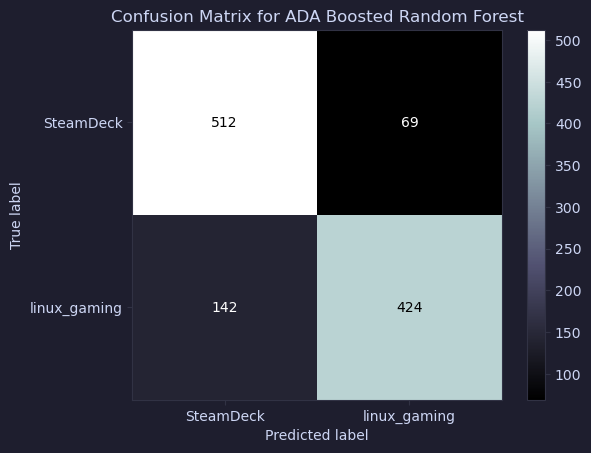

In [26]:
# Make predictions on the test set
y_pred_ada_rf = ada_rf_gs.predict(X_test_cv)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_ada_rf, labels=ada_rf_gs.classes_)

cm_disp = ConfusionMatrixDisplay(cm, display_labels=ada_rf_gs.classes_);

cm_disp.plot(cmap='bone')

# Set the title for the plot
plt.title("Confusion Matrix for ADA Boosted Random Forest")

# Save the figure to a file
# plt.savefig("../images/confusion_matrix_ada_rf.png", dpi=300, bbox_inches='tight')

plt.show()

### ADA Boosted Logistic Regression

In [27]:
ada_log = AdaBoostClassifier(estimator=LogisticRegression())

ada_log_params = {
    'estimator__penalty': ['l1', 'l2', 'elasticnet', None],
    'estimator__solver': ['saga'],
    'estimator__C': [0.1, 1, 10],
    'estimator__random_state': [42],
    'estimator__max_iter': [10000],
    'learning_rate': [0.1, 1, 5],
    'n_estimators': [50, 100],
    'random_state': [42]
}

In [28]:
# esitmate_gridsearch_time(ada_log, ada_log_params, processors=8)

In [29]:
# ada_log_gs = GridSearchCV(ada_log, param_grid=ada_log_params, verbose=1, n_jobs=-1)

# ada_log_gs.fit(X_train_cv, y_train)

# with open('../models/ada_boost_log_gridsearch_title_model.pkl', 'wb') as pickle_out:
    # pickle_out = pickle.dump(ada_log_gs, pickle_out)

In [30]:
with open('../models/ada_boost_log_gridsearch_title_model.pkl', 'rb') as pickle_in:
    ada_log_gs = pickle.load(pickle_in)

In [31]:
ada_log_gs.best_estimator_

AdaBoostClassifier(estimator=LogisticRegression(C=10, max_iter=10000,
                                                random_state=42,
                                                solver='saga'),
                   learning_rate=1, n_estimators=100, random_state=42)

In [32]:
ada_log_gs.best_score_

0.8252428827730949

In [33]:
ada_log_gs.best_params_

{'estimator__C': 10,
 'estimator__max_iter': 10000,
 'estimator__penalty': 'l2',
 'estimator__random_state': 42,
 'estimator__solver': 'saga',
 'learning_rate': 1,
 'n_estimators': 100,
 'random_state': 42}

In [34]:
ada_log_gs.score(X_train_cv, y_train), ada_log_gs.score(X_test_cv, y_test)

(0.902587961616749, 0.8221447253705318)

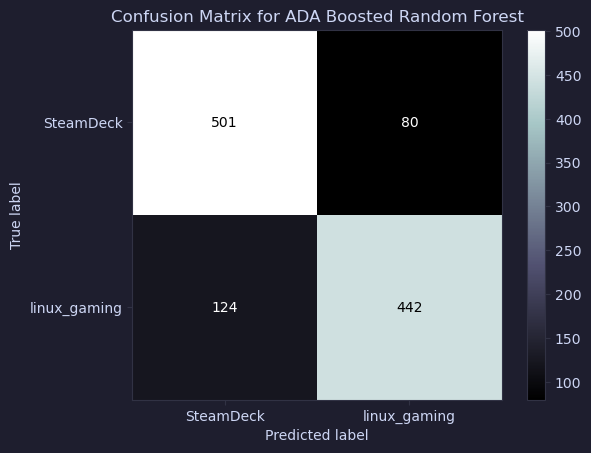

In [35]:
# Make predictions on the test set
y_pred_ada_log = ada_log_gs.predict(X_test_cv)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_ada_log, labels=ada_log_gs.classes_)

cm_disp = ConfusionMatrixDisplay(cm, display_labels=ada_log_gs.classes_);

cm_disp.plot(cmap='bone')

# Set the title for the plot
plt.title("Confusion Matrix for ADA Boosted Random Forest")

# Save the figure to a file
# plt.savefig("../images/confusion_matrix_ada_log.png", dpi=300, bbox_inches='tight')

plt.show()

### Stacking Model

In [36]:
level1_estimators = [
    ('rf', RandomForestClassifier()),
    ('knn', KNeighborsClassifier()),
    ('bag', BaggingClassifier())
]


stacked_model = StackingClassifier(estimators=level1_estimators,
                                 final_estimator=LogisticRegression())

stack_param = {
    'rf__n_estimators': [100, 150],
    'rf__max_depth': [2, 3],
    'rf__min_samples_split': [3, 4],
    'rf__min_samples_leaf': [2, 3],
    'rf__random_state': [42],
    'knn__n_neighbors': [3, 5],
    'bag__n_estimators': [100, 150],
    'bag__random_state': [42],
    'final_estimator__penalty': ['l1', 'l2', 'elasticnet', None],
    'final_estimator__solver': ['saga'],
    'final_estimator__C': [0.1, 1, 10],
    'final_estimator__random_state': [42],
    'final_estimator__max_iter': [10000],
}

In [37]:
# The gridsearch doesn't lead to time estimates that I like, so let's instead use a random search
# esitmate_gridsearch_time(stacked_model, stack_param, processors=8)

In [38]:
# stacked_rs = RandomizedSearchCV(stacked_model, param_distributions=stack_param, n_iter=100, n_jobs=-1, verbose=2)
# 
# stacked_rs.fit(X_train_cv, y_train)
# 
# with open('../models/stacked_log_randomsearch_title_model.pkl', 'wb') as pickle_out:
    # pickle_out = pickle.dump(stacked_rs, pickle_out)

In [39]:
with open('../models/stacked_log_randomsearch_title_model.pkl', 'rb') as pickle_in:
    stacked_rs = pickle.load(pickle_in)

In [40]:
stacked_rs.best_estimator_

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=3,
                                                       min_samples_leaf=3,
                                                       min_samples_split=3,
                                                       random_state=42)),
                               ('knn', KNeighborsClassifier(n_neighbors=3)),
                               ('bag',
                                BaggingClassifier(n_estimators=150,
                                                  random_state=42))],
                   final_estimator=LogisticRegression(C=1, max_iter=10000,
                                                      penalty='l1',
                                                      random_state=42,
                                                      solver='saga'))

In [41]:
stacked_rs.best_params_

{'rf__random_state': 42,
 'rf__n_estimators': 100,
 'rf__min_samples_split': 3,
 'rf__min_samples_leaf': 3,
 'rf__max_depth': 3,
 'knn__n_neighbors': 3,
 'final_estimator__solver': 'saga',
 'final_estimator__random_state': 42,
 'final_estimator__penalty': 'l1',
 'final_estimator__max_iter': 10000,
 'final_estimator__C': 1,
 'bag__random_state': 42,
 'bag__n_estimators': 150}

In [42]:
stacked_rs.best_score_

0.817682627534613

In [43]:
stacked_rs.score(X_train_cv, y_train), stacked_rs.score(X_test_cv, y_test)

(0.9741203838325094, 0.8125544899738448)

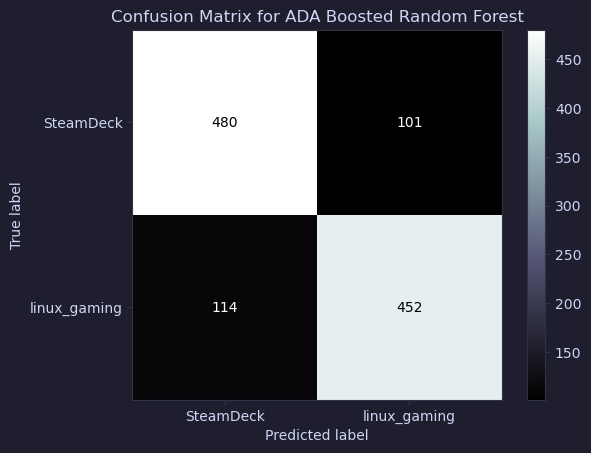

In [44]:
# Make predictions on the test set
y_pred_stack = stacked_rs.predict(X_test_cv)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_stack, labels=stacked_rs.classes_)

cm_disp = ConfusionMatrixDisplay(cm, display_labels=stacked_rs.classes_);

cm_disp.plot(cmap='bone')

# Set the title for the plot
plt.title("Confusion Matrix for ADA Boosted Random Forest")

# Save the figure to a file
# plt.savefig("../images/confusion_matrix_stacked.png", dpi=300, bbox_inches='tight')

plt.show()

## Comparison Table of Metrics

Using some slightly modified code form Chat-GPT (GPT-4), we can put all the metrics into a nice table using a pandas dataframe. First we check the classes are the same order for all three models using the transitive property. Since the label classes are the same for all three models we can safely map for the models uniformly. We can make a data frame for our various metrics and then loop through the models to add their metric calculations into the dataframe. This puts their scores right next to each other for easy comparison.

In [45]:
(ada_rf_gs.classes_ == ada_log_gs.classes_) & (ada_log_gs.classes_ == stacked_rs.classes_)

array([ True,  True])

In [46]:
models = [ada_rf_gs, ada_log_gs, stacked_rs]
model_names = ['ADA Boosted Random Forest', 'ADA Boosted Logistic Regression', 'Stacked Model']

# Create an empty DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'Precision', 'Specificity', 'F1 Score', 'ROC AUC'])

# Calculate metrics and store them in the DataFrame
for model, model_name in zip(models, model_names):
    # Get predictions
    y_pred = model.predict(X_test_cv)

    # Remap labels for y_test and y_pred
    y_test_mapped = y_test.map({'SteamDeck': 0, 'linux_gaming': 1})
    y_pred_mapped = pd.Series(y_pred).map({'SteamDeck': 0, 'linux_gaming': 1})
    
    # Calculate Accuracy Scores
    accuracy = accuracy_score(y_test_mapped, y_pred_mapped)

    # Calculate recall and precision
    recall = recall_score(y_test_mapped, y_pred_mapped)
    precision = precision_score(y_test_mapped, y_pred_mapped)

    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(y_test_mapped, y_pred_mapped).ravel()
    specificity = tn / (tn + fp)
    
    # Calculate F1 Score
    f1 = f1_score(y_test_mapped, y_pred_mapped)
    
    # Calculate ROC AUC SCore
    roc_auc = roc_auc_score(y_test_mapped, y_pred_mapped)

    # Add metrics to the DataFrame
    metrics_row = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Recall': [recall],
        'Precision': [precision],
        'Specificity': [specificity],
        'F1 Score': [f1],
        'ROC AUC': [roc_auc]
    })
    
    metrics_df = pd.concat([metrics_df, metrics_row], ignore_index=True)

# Display the metrics DataFrame
metrics_df.head()

,Model,Accuracy,Recall,Precision,Specificity,F1 Score,ROC AUC
0,ADA Boosted Random Forest,0.816042,0.749117,0.860041,0.881239,0.800755,0.815178
1,ADA Boosted Logistic Regression,0.822145,0.780919,0.846743,0.862306,0.812500,0.821613
2,Stacked Model,0.812554,0.798587,0.817360,0.826162,0.807864,0.812374


### ROC 

Again, with modifications of some code from Chat GPT we can for loop over ROC curves to get them all on the same image. Looking at the graphs, they are all pretty similar, and all out preform each other at different points. None of them look outright better than the other. For some reason the graph shows a different AUC from the the `roc_auc` function before, even though we are using it again here in the `roc_auc` parameter. 

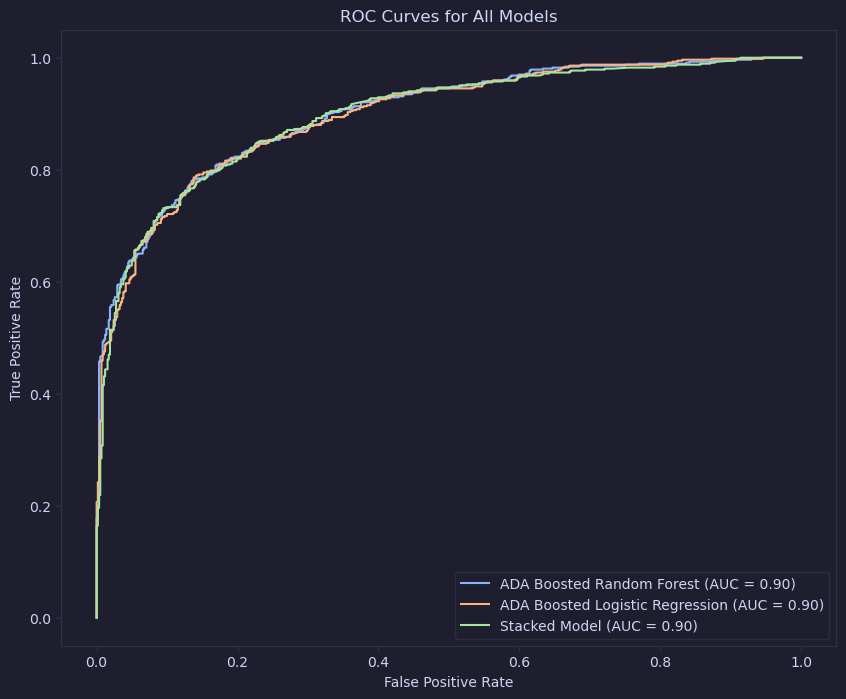

In [47]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Loop through the models and plot the ROC curve for each
for model, model_name in zip(models, model_names):
    # Get the predicted probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test_cv)[:, 1]
    
    # Calculate the AUC score
    auc = roc_auc_score(y_test_mapped, y_pred_proba)
    
    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_test_mapped, y_pred_proba)
    
    # Create the display object and plot the ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=model_name)
    display.plot(ax=ax)

# Add labels and legend
ax.set_title('ROC Curves for All Models')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')

# Display the plot
plt.show()

## Results 

Let's recreate the table of the scores for the different models.

|Model |Accuracy|Recall|Precision|Specificity|F1 Score|ROC AUC|
|---|---|---|---|---|---|---|
|ADA Boosted Random Forest|0.816042|0.749117|<font color=green>0.860041</font>|<font color=green>0.881239</font>|0.800755|0.815178|
|ADA Boosted Logistic Regression|<font color=green>0.822145</font>|0.780919|0.846743|0.862306|<font color=green>0.812500</font>|<font color=green>0.821613</font>|
|Stacked Model|0.812554|<font color=green>0.798587</font>|0.817360|0.826162|0.807864|0.812374|

The different models perform better on different metrics. The ADA Boosted Logistic Regression seems to being doing well in that it out preforms the other two models in 3 metrics. In this model we see a good scoring in Accuracy, F1 Score, and ROC AUC.

### Top Misclassified Words

Let's looks at the top words in the observations that were misclassified. Here's some modified code from Chat-GPT turned into a loop. It grabs the indexes of the misclassified observations, which is what I needed, to make a new dataframe with just them, and then makes a new top 10 words plot like the ones we made in during EDA.

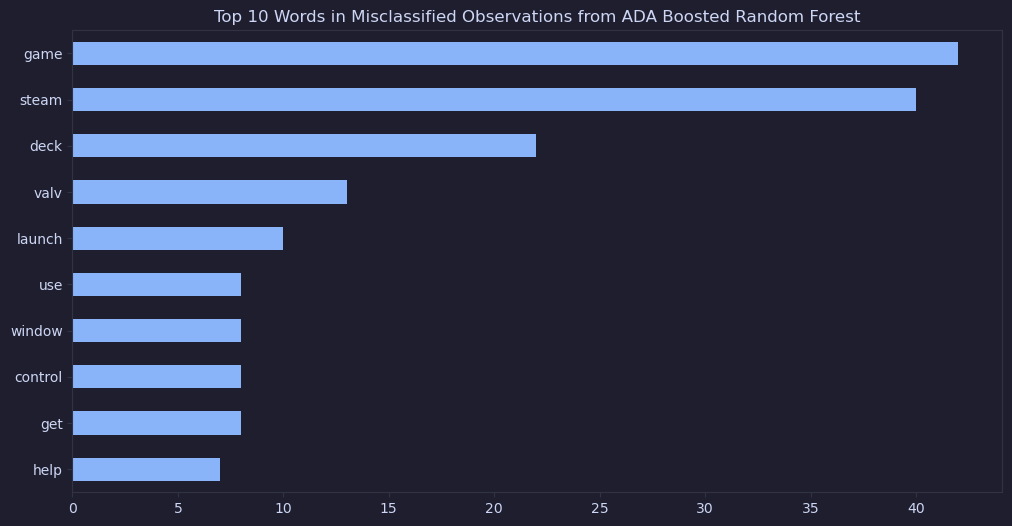

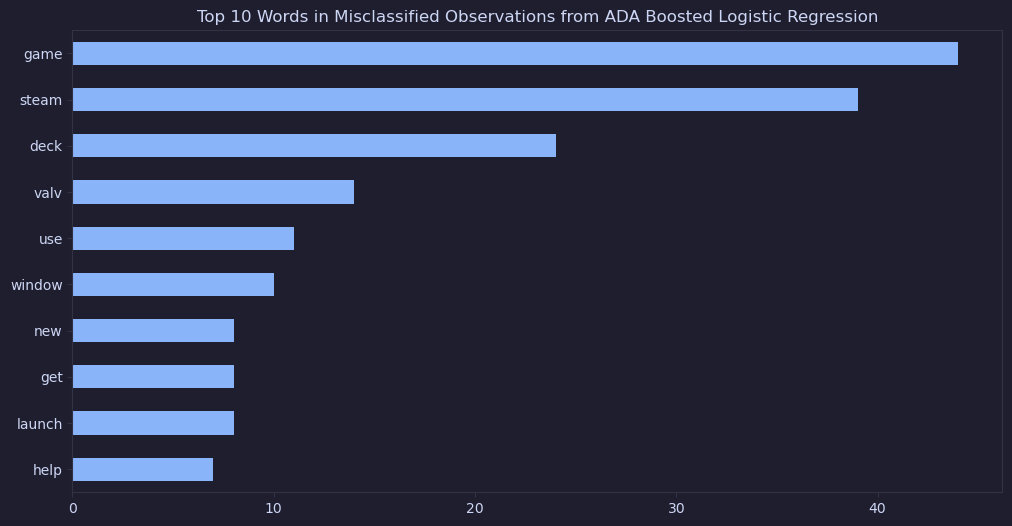

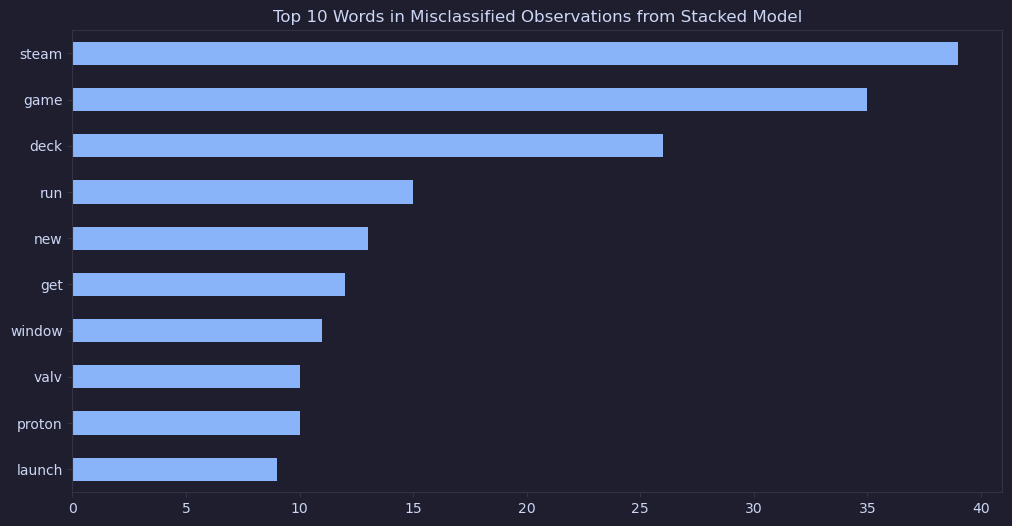

In [48]:
for model, model_name in zip(models, model_names):
    # Get predictions
    y_pred = model.predict(X_test_cv)
    
    # Find the misclassified observations
    misclassified = (y_pred != y_test)
    
    # Get the indices of the misclassified observations
    misclassified_indices = y_test[misclassified].index
    
    # Filter the vectorized data to keep only the misclassified observations
    misclassified_vect_df = X_test_cv[misclassified]
    
    # Convert the filtered vectorized data to a DataFrame
    misclassified_vect_df = pd.DataFrame(misclassified_vect_df.toarray(), columns=cvec.get_feature_names_out(), index=misclassified_indices)
    
    # Calculate the top 10 word pairs in the misclassified observations
    top_10_words = misclassified_vect_df.sum().sort_values(ascending=False).head(10)
    
    # Plot the top 10 word pairs
    fig, ax = plt.subplots(figsize=(12, 6))
    top_10_words.plot(kind='barh', ax=ax)
    ax.set_title(f'Top 10 Words in Misclassified Observations from {model_name}')
    ax.invert_yaxis()
    # fig.savefig(f'../images/top_10_words_misclassified_{model_name}.png')

Unsurprisingly the words that are common among the misclassified posts heavily include words like '*steam*' (which could in reference to the store plaftform, software, or part of the name of SteamDeck), '*deck*', '*game*', '*valve*', and '*launch*' which are pretty big key words in the topics that would be very popular in both subreddits. Posts about the steam deck itself, steam's software, software launching, game launchings, steam deck launch, etc are going to be all over bother sub reddits, and seeing the high good accuracy scores still after knowing that these words were much more prevalent than just the ones showing up in the misclassified lists, is honestly impressive.

## Conclusions

After these results, the most promising model looks to be the ADA Boosted Logistic Regression. It had the highest accuracy, which is actually a good metric in this situation. Accuracy's importance is dependent on the data set and the problem statement. Many times, accuracy can be a red herring metric, especially in highly imbalanced data. However, these models were trained on balanced data of 50-50, so getting an 82% accuracy is pretty good when the baseline is 50%. But the other reason why accuracy is good in this situation is because there isn't that much difference between the value of the different misclasifications. We don't weight false positives any differently from false negatives. In something like a insurance qualifications, fraud detection, or medical screenings for diseases there can be a big difference of value over false positives and false negatives, and you would want to optimize to minimize one over the other. However, in this NLP Classification problem, we don't really mind one over the other, they are pretty equal. 

This high accuracy is further supported also by a good F1 score and ROC AUC. This shows that the model is pretty well balanced at predicting either subreddit and gets a good balance of the two different misclassifications, and does good a picking up the true positives and negatives. This shows good potential for the model to be further explored. 

Further testing could be done by trying out different Boosting algorithms on the Logistic Regresssion. We just checked ADA Boosting here, but it would be interesting to see how well the other Boosting algorithms preform, like Gradient Boosting and XGBoost.

### Hypothesis Check

It seems our hypothesis was correct. Even though the two subreddits might seem very similar on the surface, they are actually pretty different, and guessing between the two isn't that hard. Surprisingly we even didn't have that bad of misclassifications of r/SteamDeck posts as r/linux_gaming (in this case, that would be a false positive). The metrics were well balanced, and the accuracy was pretty good. 